# STAT207 Mini-Project #1 - How does MLB position affect how players gain their value?


Ben Estacio

In [1]:
#Imports here
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

## 1. Introduction

Hello, welcome to my STAT207 miniproject 1! One of my favorite hobbies is watching Major League Baseball.
While I obviously love watching the games themselves, I also really enjoy diving into baseball analytics and looking at the statistics behind the game. In my project, I'll be answering the question: 

**How does the nature of the relationship between OPS and WAR per game change for different positions?**

I know this sounds pretty confusing to someone who doesn't know anything about baseball, but I promise that I'll explain what all of these terms mean and how they relate to each other eventually. In simpler terms, I want to find out the difference in how different defensive positions gain value; which positions gain their value through offensive stats and which ones gain value through defense?

This information would be very helpful for anyone who wants to evaluate the performance of baseball players, such as scouts, coaches, or baseball executives. Depending on the results of this question, they may evaluate a player differently; for example, a shortstop who doesn't hit well could be more valuable than a first baseman who doesn't hit well.

## 2. Dataset Discussion

In [2]:
df = pd.read_csv("2024batting.csv")
print("Number of rows: " + str(df.shape[0]))
df.head()

Number of rows: 895


,Rk,Player,Age,Team,Lg,WAR,G,PA,AB,R,...,Rbat+,TB,GIDP,HBP,SH,SF,IBB,Pos,Awards,Player-additional
0,1,Jarren Duran*,27,BOS,AL,8.7,160,735,671,111,...,134.0,330,6,6,1,3,1,*87,ASMVP-8,duranja01
1,2,Shohei Ohtani*,29,LAD,NL,9.2,159,731,636,134,...,190.0,411,7,6,0,5,10,*D,ASMVP-1SS,ohtansh01
2,3,Gunnar Henderson*,23,BAL,AL,9.1,159,719,630,118,...,157.0,333,2,7,0,4,1,*6/D,ASMVP-4,hendegu01
3,4,Marcus Semien,33,TEX,AL,4.1,159,718,650,101,...,100.0,254,9,3,0,1,2,*4,AS,semiema01
4,5,Juan Soto*,25,NYY,AL,7.9,157,713,576,128,...,179.0,328,10,4,0,4,2,*9/7DH,ASMVP-3SS,sotoju01


To answer this question, I decided to use Baseball-Reference's 2024 Standard Batting dataset; it can be found at https://www.baseball-reference.com/leagues/majors/2024-standard-batting.shtml (though there isn't a way to export directly to CSV, you'll need to convert the table to CSV and then copy/paste into a text document). I retrieved this data on 2/19/25, though that doesn't really matter because the 2024 season has passed, so this data likely won't change in the future. The data was collected by simply recording each player's hitting stats from the 2024 MLB season. Each row in the dataset represents a player and their statline. Any player who appeared an a lineup in any game this season appears as a row in the DataFrame, so all of our data is represented; therefore, anyone wanting to use this data does not have to worry about missing players or underrepresentation.

The three variables I'll be using in this analysis are:

- **Wins Above Replacement per Game (WAR/G)**

Wins Above Replacement is a statistic that measures a player's overall value in all aspects of the game, meaning it takes hitting, running, and defense into account. A higher WAR means a more valuable player. One caveat to using WAR is that it's a cumulative stat, meaning players who played in fewer games due to injury may seem less valuable then they actually are. To combat this, I'll turn WAR into a rate stat by dividing it by games played. This isn't a column in the dataset, so I'll have to calculate this manually.

- **On-Base Plus Slugging (OPS)**

On-Base Plus Slugging adds a player's on-base percentage (how often they successfully reach base) and slugging percentage (how many bases they reach per at-bat) to create an offensive statistic that is a good measure of how good a player is at hitting.

- **Position**

The defensive position each player plays. Because many players have played multiple positions, Baseball-Reference represents position as a string of numbers and symbols (such as *9/7DH). I'll have to make some changes to this column to limit each player to one position and make it easier to read.

## 3. Dataset Cleaning

In [3]:
original_length = len(df)
original_length

895

We currently have 895 players in our dataset, but we want to get rid of data that isn't useful to us.
First, I'll get rid of all of the columns that I won't be using:

In [4]:
df = df[["Player", "Pos", "G", "WAR", "OPS"]]
df.head()

,Player,Pos,G,WAR,OPS
0,Jarren Duran*,*87,160,8.7,0.834
1,Shohei Ohtani*,*D,159,9.2,1.036
2,Gunnar Henderson*,*6/D,159,9.1,0.893
3,Marcus Semien,*4,159,4.1,0.699
4,Juan Soto*,*9/7DH,157,7.9,0.989


### Data Cleaning - Missing Values

Now check for and remove explicit missing values:

In [5]:
df.isna().sum()

Player     0
Pos        0
G          0
WAR        2
OPS       94
dtype: int64

In [6]:
df = df.dropna()

We can see here that there are no implicit missing values:

In [7]:
df.dtypes

Player     object
Pos        object
G           int64
WAR       float64
OPS       float64
dtype: object

In [8]:
original_length - len(df)

96

In total, we dropped 96 rows with missing values from our dataset.

### Data Cleaning - Sample Size
To make sure all of the positions are represented in the dataset, we should first make the "Pos" column more readable and limit each player to their primary position. Currently, each number/letter in the position column represents a position that the player played; to get a player's primary position, we need to find the first number/letter in the position column, then replace it with something more understandable.

In [9]:
# Function to replace position
def isolatePos(pos):
    for char in pos:
        if (char == "D"):
            return "Designated Hitter"
        elif (char == "1"):
            return "Pitcher"
        elif (char == "2"):
            return "Catcher"
        elif (char == "3"):
            return "1st Baseman"
        elif (char == "4"):
            return "2nd Baseman"
        elif (char == "5"):
            return "3rd Baseman"
        elif (char == "6"):
            return "Shortstop"
        elif (char == "7"):
            return "Left Fielder"
        elif (char == "8"):
            return "Center Fielder"
        elif (char == "9"):
            return "Right Fielder"
    return "Did not play field"

# Apply function to Pos column
df["Pos"] = df["Pos"].apply(lambda x: isolatePos(x))
df

,Player,Pos,G,WAR,OPS
0,Jarren Duran*,Center Fielder,160,8.7,0.834
1,Shohei Ohtani*,Designated Hitter,159,9.2,1.036
2,Gunnar Henderson*,Shortstop,159,9.1,0.893
3,Marcus Semien,2nd Baseman,159,4.1,0.699
4,Juan Soto*,Right Fielder,157,7.9,0.989
...,...,...,...,...,...
796,Orelvis Martínez,2nd Baseman,1,0.0,0.667
798,Luis Castillo,Pitcher,1,0.0,0.000
799,Daniel Johnson*,Right Fielder,1,0.0,0.000
800,Scott McGough,Pitcher,2,0.0,0.000


In [10]:
df["Pos"].value_counts()

Pos
3rd Baseman          109
Left Fielder         105
Catcher              105
Right Fielder        104
2nd Baseman           94
1st Baseman           85
Center Fielder        76
Shortstop             65
Designated Hitter     54
Pitcher                2
Name: count, dtype: int64

We can see that there are only 2 pitchers left in the dataset, which is way too small of a sample size, so we will get rid of them.

In [11]:
original_length2 = len(df)
df = df[df["Pos"] != "Pitcher"]
original_length2 - len(df)

2

We got rid of another 2 entries in this section.

### Data Cleaning - Single/Double Outlier Inspection

Before we look at boxplots, I'll create the WAR per game column.

In [12]:
df["WAR/G"] = df["WAR"] / df["G"]

C:\Users\benja\AppData\Local\Temp\ipykernel_3512\777080988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["WAR/G"] = df["WAR"] / df["G"]


Let's take a look at two boxplots: one for our WAR/G stat, and one for OPS.

<Axes: xlabel='WAR/G'>

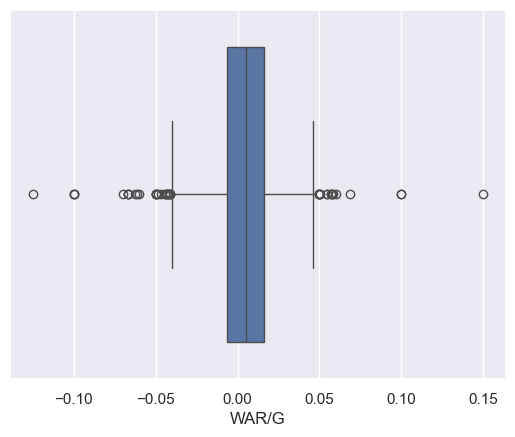

In [13]:
sns.boxplot(x=df["WAR/G"])

<Axes: xlabel='OPS'>

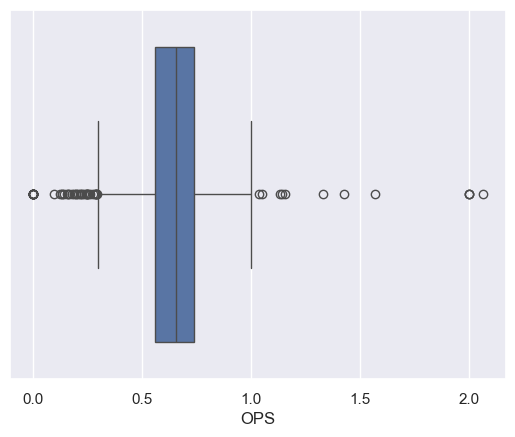

In [14]:
sns.boxplot(x=df["OPS"])

We can see from both of these boxplots that there are many significant outliers in both plots, both high and low. Let's examine the nature of some of the outliers, specifically the low outliers from the WAR/G plot:

In [15]:
df[df["WAR/G"] < -.05]

,Player,Pos,G,WAR,OPS,WAR/G
376,Nick Senzel,3rd Baseman,10,-0.7,0.262,-0.070000
430,Nick Ahmed,2nd Baseman,2,-0.2,0.286,-0.100000
593,Zack Short,2nd Baseman,2,-0.2,0.000,-0.100000
695,Niko Goodrum#,Left Fielder,13,-0.8,0.291,-0.061538
697,Niko Goodrum#,3rd Baseman,4,-0.5,0.133,-0.125000
698,Nacho Alvarez Jr.,2nd Baseman,8,-0.5,0.256,-0.062500
717,Keston Hiura,2nd Baseman,10,-0.6,0.296,-0.060000
741,Liván Soto*,Designated Hitter,1,-0.1,0.000,-0.100000
758,Kevin Alcántara,Right Fielder,3,-0.2,0.200,-0.066667
783,Brian Anderson,Right Fielder,3,-0.2,0.000,-0.066667


As you can see, it turns out all of the significant outliers were caused by small sample sizes from players who played very few games, so we can get rid of these outliers by setting a minimum amount of games played in our dataset.

In [16]:
original_length3 = len(df)
df = df[df["G"] >= 25]
original_length3 - len(df)

204

We ended up dropping 204 more rows from our dataset to account for these outliers. While this means our new dataset is less representative of the entire MLB, this was necessary to answer the research question because outliers would skew our results too heavily.

Finally, let's inspect the scatterplot of the relationship between OPS and WAR/G.

<Axes: xlabel='OPS', ylabel='WAR/G'>

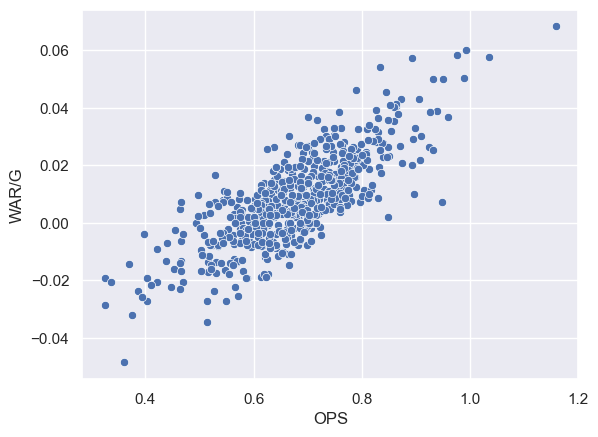

In [17]:
sns.scatterplot(x="OPS", y="WAR/G", data=df)

No significant outliers here.

### Other Data Cleaning

I also noticed that players who played for multiple teams in the season have multiple rows in the dataset. I considered removing these, but decided not to, as these rows have the same name but different data (one row for each team they played with), so there isn't really a reason to remove them. Other than that, there is no more data cleaning to do, so we are ready to answer our research question.

## 4. <u>Research Question</u>: How does the Relationship between `x` and `y` Change based on Different Values of `z` in the Dataset?

The research question I aim to answer is:

**How does the nature of the relationship between OPS and WAR per game change for different positions?**

To visualize how different positions (a categorical variable) affect the relationship between OPS and WAR per game (two numerical variables), let's look at the scatterplot of the relationship between OPS and WAR/G, this time color coded to represent position:

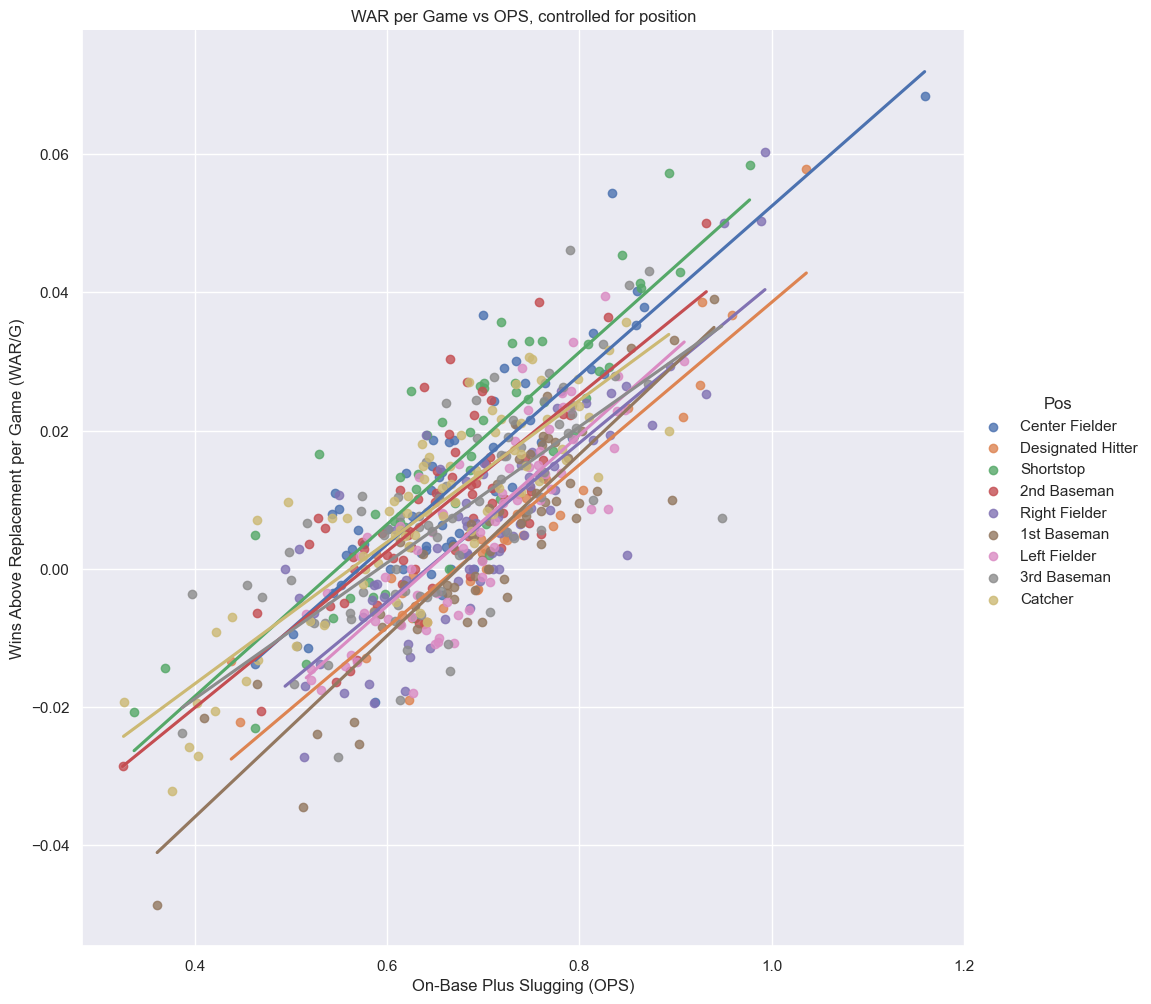

In [23]:
plot = sns.lmplot(x="OPS", y="WAR/G", hue="Pos", data=df, ci=False, height=10)
plt.title("WAR per Game vs OPS, controlled for position")
plt.xlabel("On-Base Plus Slugging (OPS)")
plt.ylabel("Wins Above Replacement per Game (WAR/G)")
plt.show()

In [19]:
df[["Pos", "OPS", "WAR/G"]].groupby("Pos").corr()

OPS     WAR/G
Pos                                        
1st Baseman       OPS    1.000000  0.893155
                  WAR/G  0.893155  1.000000
2nd Baseman       OPS    1.000000  0.778126
                  WAR/G  0.778126  1.000000
3rd Baseman       OPS    1.000000  0.732361
                  WAR/G  0.732361  1.000000
Catcher           OPS    1.000000  0.869232
                  WAR/G  0.869232  1.000000
Center Fielder    OPS    1.000000  0.861594
                  WAR/G  0.861594  1.000000
Designated Hitter OPS    1.000000  0.932139
                  WAR/G  0.932139  1.000000
Left Fielder      OPS    1.000000  0.828237
                  WAR/G  0.828237  1.000000
Right Fielder     OPS    1.000000  0.832175
                  WAR/G  0.832175  1.000000
Shortstop         OPS    1.000000  0.873956
                  WAR/G  0.873956  1.000000

Direction: For all positions, the direction of the correlation is positive. As offensive production increases, players gain more value.

Shape: All positions exhibit a linear relationship between OPS and WAR/G. 

Strength: For all positions, the strength of the correlation between OPS and WAR/G is strong. The strongest correlations belong to first basemen and designated hitters, two heavily offensive-minded positions.

Outliers: While there are a few outliers here and there, none of them are very significant and there isn't any particular position that shows more outliers than others.

Slope: There are some minor differences in slope among the positions. Catchers and third basemen have the smallest slopes, while the steepest slopes belong to first basemen and shortstops. Overall, though, the slopes are largely similar.

While it is not one of the descriptive statistics, it's worth noting that the intercepts of the lines of best fit have considerably different intercepts. There's a pattern in these intercepts: important defensive positions like shortstop and center field have higher intercepts while positions that are more offensive-minded like first base and designated hitter have lower intercepts.

### Answer to the Research Question

**While position does not have a dramatic effect on the relationship between WAR/G and OPS, it does affect the intercept of the relationship; positions with higher defensive value have higher intercepts than higher offensive value.**

## 5. Conclusion

### What does this mean?

The relatively equal slopes of the best-fit lines mean that value and offensive production have roughly the same association for all positions. Despite this similarity, the different intercepts of the lines offer a good insight into how each position gains value. For example, take at the line representing shortstops and the line representing designated hitters and look at the values when OPS is .800 (indicating a good hitter). A shortstop who has an OPS of .800 has much more value than a designated hitter with the same OPS, because much of a shortstop's value lies in defensive ability, so a shortstop who hits well is incredibly valuable. Meanwhile, a designated hitter with the same OPS is less valuable, as they bring no value defensively (as they don't play the field) and are "expected" to hit well in order to be valuable.

### Shortcomings of this analysis

This analysis doesn't really indicate that the relationship between value and offensive production differs from position to position like I was expecting, since the slopes are mostly the same. Additionally, we removed many rows from this dataset during cleaning so the remaining rows are not as representative of the league as a whole. As a result, analysts using this conclusion may need to be wary that this isn't an entirely accurate representation of the MLB.

### Future work

While the relationship between offensive production and overall value may not change from position to position, I am more confident that if we had data on defensive stats we would see a lot more variation in the relationship between offensive and defensive stats based on position.